# Texas Flu and Pneumonia deaths

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
idx=pd.IndexSlice

In [64]:
# Flu and Pneumonia underlying death data from CDC WONDER. Query used: 
# https://wonder.cdc.gov/controller/saved/D76/D91F167
udf = pd.read_csv(
    "data/tx-pi-deaths-underlying-deaths-2010-thru-2018.csv",
    usecols=[2,3])

# the last rows are metadata that should not be included
# in the dataset:
udf = udf.dropna()

# rename columns:
old2new_cols = {
    "Month Code": "date",
    "Deaths": "deaths"}
udf = udf.rename(columns=old2new_cols)

# convert date strings to datetime objects:
udf.loc[:,"date"] = udf["date"].apply(lambda x: pd.to_datetime(x,format="%Y/%m"))

# set date column as index:
udf = udf.set_index(["date"])

In [65]:
# Flu and pneumonia multiple cause of death data from CDC WONDER. Query used:
# https://wonder.cdc.gov/controller/saved/D77/D91F168
mdf = pd.read_csv(
    "data/tx-pi-deaths-multiple-deaths-2010-thru-2018.csv",
    usecols=[2,3])

# apply the same formatting as the underlying death data:
mdf = mdf.dropna()
mdf = mdf.rename(columns=old2new_cols)
mdf.loc[:, "date"] = mdf.date.apply(lambda x: pd.to_datetime(x,format="%Y/%m"))
mdf = mdf.set_index(["date"])

In [66]:
# calculate P&I multiple cause of death per year:
mpi_df = mdf.resample("Y", label="left").sum()

# offset to Jan 1 of each year:
mpi_df.index = mpi_df.index + pd.Timedelta(days=1)
mpi_df

,deaths
date,
2010-01-01,10313.0
2011-01-01,10456.0
2012-01-01,10740.0
2013-01-01,11636.0
2014-01-01,11808.0
2015-01-01,11747.0
2016-01-01,11045.0
2017-01-01,11558.0
2018-01-01,12394.0


<IPython.core.display.Javascript object>


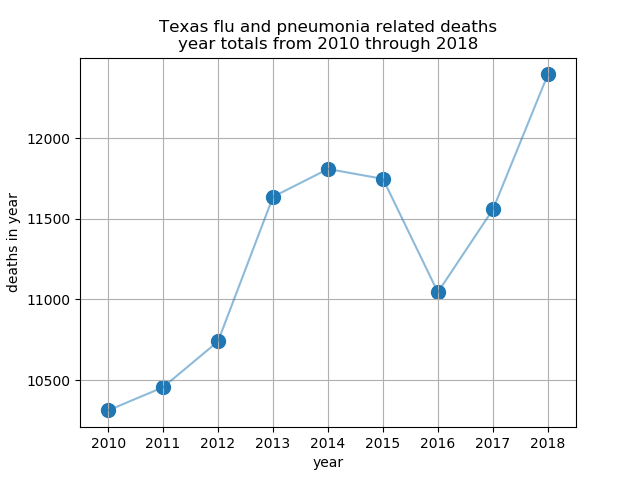

Text(0, 0.5, 'deaths in year')

In [67]:
# plot P&I multiple cause of death data per year:
plt.figure()
plt.title("""Texas flu and pneumonia related deaths
year totals from 2010 through 2018""")
plt.scatter(
    mpi_df.index,
    mpi_df.deaths,
    s=100)
plt.plot(
    mpi_df.index,
    mpi_df.deaths,
    alpha=0.5)
plt.grid()
plt.xlabel("year")
plt.ylabel("deaths in year")


# 2017-2018 Flu Season

<IPython.core.display.Javascript object>


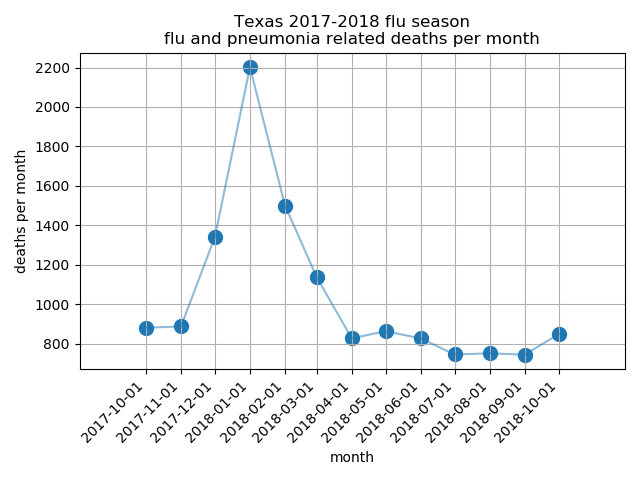

In [68]:
# looks like 2017-2018 flu season was the most severe. 
# Flu seasons seem to be defined as Oct to Oct. 
plt.figure()
plt.title("""Texas 2017-2018 flu season
flu and pneumonia related deaths per month""")
plt.scatter(
    mdf.loc["2017-10-01":"2018-10-01",:].index,
    mdf.loc["2017-10-01":"2018-10-01","deaths"],
    s=100)
plt.plot(
    mdf.loc["2017-10-01":"2018-10-01",:].index,
    mdf.loc["2017-10-01":"2018-10-01","deaths"],
    alpha=0.5)
plt.xticks(
    mdf.loc["2017-10-01":"2018-10-01",:].index, 
    rotation=45, 
    ha="right")
plt.xlabel("month")
plt.ylabel("deaths per month")
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


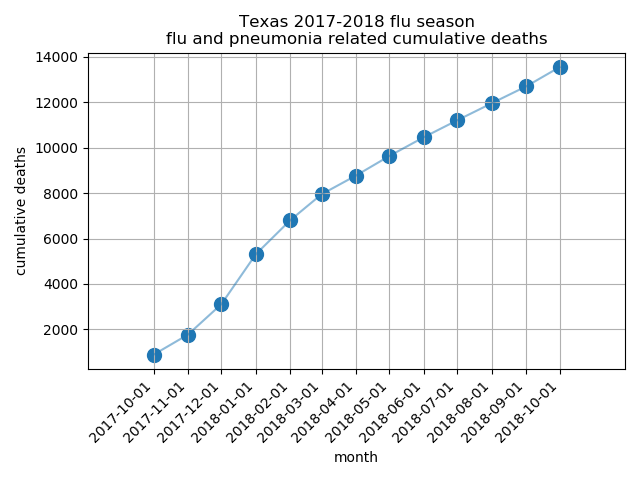

In [69]:
# same data, but as a cumulative sum:
plt.figure()
plt.title("""Texas 2017-2018 flu season
flu and pneumonia related cumulative deaths""")
plt.scatter(
    mdf.loc["2017-10-01":"2018-10-01",:].index,
    mdf.loc["2017-10-01":"2018-10-01","deaths"].cumsum(),
    s=100)
plt.plot(
    mdf.loc["2017-10-01":"2018-10-01",:].index,
    mdf.loc["2017-10-01":"2018-10-01","deaths"].cumsum(),
    alpha=0.5)
plt.xticks(
    mdf.loc["2017-10-01":"2018-10-01",:].index, 
    rotation=45, 
    ha="right")
plt.xlabel("month")
plt.ylabel("cumulative deaths")
plt.grid()
plt.tight_layout()

In [70]:
# slice out 2017-2018 flu season data:
# 2017-2018 flu season defined from October 1, 2017 through October 1, 2018.
# The flu season therefore does not include the flu deaths that occurred in 
# October 2018, so we need to exclude October 2018 from the slice. 
flu_season_deaths = mdf.loc["2017-10-01":"2018-09-01",:]
monthly_flu_deaths = flu_season_deaths.resample("M").sum()
monthly_flu_deaths["cumulative"] = monthly_flu_deaths.cumsum()

# calculate days since season start:
monthly_flu_deaths["days_since"] = monthly_flu_deaths.index - flu_season_deaths.index[0]
monthly_flu_deaths.loc[:,"days_since"] = monthly_flu_deaths.days_since.dt.days
monthly_flu_deaths

,deaths,cumulative,days_since
date,,,
2017-10-31,881.0,881.0,30
2017-11-30,887.0,1768.0,60
2017-12-31,1341.0,3109.0,91
2018-01-31,2202.0,5311.0,122
2018-02-28,1500.0,6811.0,150
2018-03-31,1138.0,7949.0,181
2018-04-30,827.0,8776.0,211
2018-05-31,863.0,9639.0,242
2018-06-30,827.0,10466.0,272


# COVID-19 deaths data per month

In [71]:
# read deaths data:
import dshstexas
covid_deaths = dshstexas.read(
    "bin/data-2020-09-11/TexasCOVID19DailyCountyFatalityCountData.xlsx",
    datetime_header=True)

# we don't care about county-level data here, so let's index by date 
# instead of county:
covid_deaths = covid_deaths.transpose()
covid_deaths["cumulative"] = covid_deaths.sum(axis=1)
covid_deaths = pd.DataFrame(covid_deaths.loc[:,"cumulative"])

# let's get deaths per day:
covid_deaths["deaths"] = covid_deaths.cumulative.diff()

# deaths per month:
monthly_covid_deaths = pd.DataFrame(covid_deaths.deaths.resample("M").sum())
monthly_covid_deaths["cumulative"] = monthly_covid_deaths.deaths.cumsum()

# correct datetime index:
monthly_covid_deaths.index = monthly_covid_deaths.index + pd.Timedelta(days=1)
monthly_covid_deaths

,deaths,cumulative
2020-04-01,99.0,99.0
2020-05-01,829.0,928.0
2020-06-01,815.0,1743.0
2020-07-01,1208.0,2951.0
2020-08-01,5919.0,8870.0
2020-09-01,3671.0,12541.0
2020-10-01,114.0,12655.0


In [72]:
# counting days-since can be misleading. days-since represents the delta time in days
# from the start of data tracking to the end of the resampled index. The final value
# of days-since can be smaller or larger than the actual number of days that Texas has
# tracked COVID-19. days-since varies by the resample size and by the edge at which Pandas
# resamples the data (left or right).
#
# the output below was resampled by month to the right-hand side. monthly_covid_deaths'
# final index value is therefore 2020-10-01, or several days ahead of the actual COVID-19
# data. The final days-since value is also several days larger than the actual number 
# of elapsed days between COVID-19 start and end tracking. 
#
# We'll calculate a true days-elapsed separately:
total_covid_days = covid_deaths.index[-1] - covid_deaths.index[0]
total_covid_days = total_covid_days.days

# now get the days-since in the resampled data:
monthly_covid_deaths["days_since"] = monthly_covid_deaths.index - covid_deaths.index[0]
monthly_covid_deaths.loc[:,"days_since"] = monthly_covid_deaths.days_since.dt.days
monthly_covid_deaths

,deaths,cumulative,days_since
2020-04-01,99.0,99.0,25
2020-05-01,829.0,928.0,55
2020-06-01,815.0,1743.0,86
2020-07-01,1208.0,2951.0,116
2020-08-01,5919.0,8870.0,147
2020-09-01,3671.0,12541.0,178
2020-10-01,114.0,12655.0,208


# Compare 2017-2018 flu and available COVID-19 death data

<IPython.core.display.Javascript object>


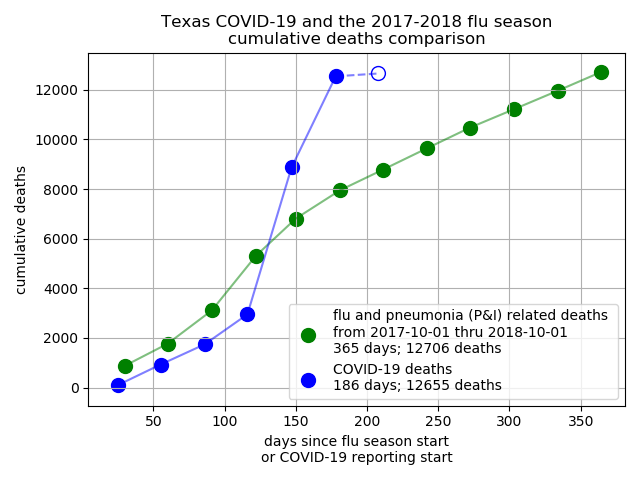

In [75]:
plt.figure()
plt.title("""Texas COVID-19 and the 2017-2018 flu season
cumulative deaths comparison""")

# flu data:
flu_label="""flu and pneumonia (P&I) related deaths 
from 2017-10-01 thru 2018-10-01
365 days; %d deaths""" %(monthly_flu_deaths.cumulative[-1])
plt.scatter(
    monthly_flu_deaths.days_since,
    monthly_flu_deaths.cumulative,
    s=100,
    color="green",
    label=flu_label)
plt.plot(
    monthly_flu_deaths.days_since,
    monthly_flu_deaths.cumulative,
    alpha=0.5,
    color="green",
    label="")

# COVID-19 data:
covid_label="""COVID-19 deaths
%d days; %d deaths""" %(
    total_covid_days,
    monthly_covid_deaths.cumulative[-1])

# the last value is preliminary:
plt.scatter(
    monthly_covid_deaths.days_since[:-1],
    monthly_covid_deaths.cumulative[:-1],
    s=100,
    color="blue",
    label=covid_label)
plt.plot(
    monthly_covid_deaths.days_since[:-1],
    monthly_covid_deaths.cumulative[:-1],
    alpha=0.5,
    color="blue",
    label="")

# September is not over, so we will visually make
# it clear that the data is incomplete:
plt.scatter(
    monthly_covid_deaths.days_since[-1],
    monthly_covid_deaths.cumulative[-1],
    s=100,
    edgecolor="blue",
    facecolor="none",
    label="")
plt.plot(
    monthly_covid_deaths.days_since[-2:],
    monthly_covid_deaths.cumulative[-2:],
    alpha=0.5,
    color="blue",
    linestyle="--",
    label="")

# finish plot:
plt.grid()
plt.legend()
plt.xlabel("days since flu season start\nor COVID-19 reporting start")
plt.ylabel("cumulative deaths")
plt.tight_layout()

# save figure:
plt.savefig("bin/PRELIM-2017-and-2018-flu-compared-to-COVID-19.png",dpi=100)